In [27]:
import pandas as pd
import numpy as np
import pyteomics.auxiliary as aux
import seaborn as sns
import matplotlib.pyplot as plt
import os, re, subprocess
import ast
#from utility_functions import *

In [32]:
pipeline="tpp"
psm_score="fval"
#pipeline="fragpipe"
working_folder = f"/project/def-marie87/vvshazia/pride_reanalysis/analysis_on_groupwalk/hybrid-psm-{pipeline}/"
savefile_path = f'{pipeline}-identified-protein-groups-all-datasets.csv.gz'
PXDs = [
    'PXD002057',
    'PXD005833',
    'PXD014258',
]

SEARCHES = [
    'canon',
    'trembl',
    'openprot',
]
DATASETS = pd.MultiIndex.from_product([PXDs,SEARCHES])
DATASETS

MultiIndex([('PXD002057',    'canon'),
            ('PXD002057',   'trembl'),
            ('PXD002057', 'openprot'),
            ('PXD005833',    'canon'),
            ('PXD005833',   'trembl'),
            ('PXD005833', 'openprot'),
            ('PXD014258',    'canon'),
            ('PXD014258',   'trembl'),
            ('PXD014258', 'openprot')],
           )

In [33]:
def classify_leadprot(x):
    x=x.replace("decoy_","")
    if 'CONTAMINANT' in x.upper():
        return 'Contam'
    elif x.startswith('II_') or x.startswith('IP_'):
        return 'NonCanon'
        # Ensembl is canonical
    else:
        return 'Canon'

def is_peptide_canonical(x):
    '''x is the list of protein classes'''
    if np.array([_=='Contam' for _ in x]).any():
        return 'Contam'
    if np.array([_=='Canon' for _ in x]).any():
        return 'Canonical'
    return 'NonCanonical'

def custom_subgroup_filter(data_,key):
    filtered_subgroups = []
    for (c,m),df in data_.groupby(['isCanonical','isModified']).__iter__():
        tmp = aux.target_decoy.qvalues(df, key=key, reverse=True, is_decoy=df.database=='D',
                                      formula=1, full_output=True, q_label='groupwise_qvalue')
        filtered_subgroups.append(tmp)

    return pd.concat(filtered_subgroups, ignore_index=True)

In [44]:
folders = {search:{dataset_name:[] for dataset_name in PXDs} for search in SEARCHES}
for dataset_name in PXDs:
    for search in SEARCHES:   
        for fld in os.scandir(os.path.join(working_folder, dataset_name, f"{dataset_name}-{search}")):
            if ".csv" in fld.name and not "_Occam" in fld.name:
                folders[search][dataset_name].append(fld)

In [15]:
psms.columns

Index(['spectrum', 'precursor_neutral_mass', 'assumed_charge',
       'retention_time_sec', 'start_scan', 'end_scan', 'index', 'protein',
       'protein_descr', 'peptide_next_aa', 'peptide_prev_aa', 'num_tol_term',
       'xcorr', 'deltacn', 'spscore', 'sprank', 'expect', 'modifications',
       'hit_rank', 'peptide', 'num_tot_proteins', 'num_matched_ions',
       'tot_num_ions', 'num_missed_cleavages', 'calc_neutral_pep_mass',
       'massdiff', 'num_matched_peptides', 'modified_peptide', 'fval', 'ntt',
       'nmc', 'massd', 'peptideprophet_probability', 'peptideprophet_ntt_prob',
       'spectrum_file', 'database', 'is decoy', 'global_q', 'xcorr_global_q',
       'expect_global_q', 'protein_classes', 'isCanonical', 'isModified',
       'custom_q', 'isTarget', 'FDRGroup', 'glob_cust_hybrid', 'searchDB',
       'PXD'],
      dtype='object')

In [39]:
def get_max_psm_score(x,psms,psm_score):
    protein_group = x.split(',')
    tmp3 = psms[psms.protein.isin(protein_group)]
    return np.max(tmp3[psm_score])

def group_is_decoy(x):
    protein_group = x.split(',')
    tmp = [_.startswith('decoy') for _ in protein_group]
    return set(tmp)

def classify_protein_group(x):
    protein_group = x.split(',')
    tmp = [classify_leadprot(_) for _ in protein_group]
    return is_peptide_canonical(tmp)

In [41]:
os.path.join(sample_fld.path)

'/project/def-marie87/vvshazia/pride_reanalysis/analysis_on_groupwalk/hybrid-psm-tpp/PXD002057/PXD002057-canon/130327_o2_03_hu_C2_2hr-protein-inference-input.pout'

In [47]:
output_files = []
for dataset_name in PXDs:
    for search in SEARCHES:  
        j = len(folders[search][dataset_name])
        for i,sample_fld in enumerate(folders[search][dataset_name]):          
            #did not go through for a long time: - skip it, try in terminal - di not work, have to skipp it
            #hybrid-psm-tpp/PXD005833/PXD005833-openprot/AM18-protein-inference-input.pout

            sample=sample_fld.name.replace(".csv","")
            sample_path=os.path.join(working_folder, dataset_name, f"{dataset_name}-{search}")
            out_path=os.path.join(sample_path, f"{sample}_protein_groups_Occam.csv")
            if (os.path.exists(out_path)) or ("openprot/AM18" in out_path): continue
            
            # Read and preprocess the dataset
            psms = pd.read_csv(os.path.join(sample_fld.path))
            print(f'({1+i}/{j})',sample_fld, psms.shape)
            psms = pd.read_csv(os.path.join(sample_fld.path))
            ##psms.modifications = psms.modifications.fillna('')
            psms = psms[psms['global_q']<=.01].copy(deep=True)
            ##psms.proteins = psms.proteins.str.split('||', regex=False)
            ##psms.proteins = psms.proteins.apply(lambda x: [re.split(r'\(\(|\)\)', _)[3] for _ in x])
            ##psms.proteins = psms.proteins.apply(lambda x: [re.sub(r'^sp\|','',_) for _ in x])
            ##psms.proteins = psms.proteins.apply(lambda x: list(set(x)))
            # try without contaminant peptides
            psms.protein=psms.protein.apply(lambda x: ast.literal_eval(x))
            psms['protein_classes'] = psms.protein.apply(lambda x: np.unique([classify_leadprot(_) for _ in x]))
            psms['isCanonical'] = psms.protein_classes.apply(is_peptide_canonical)
            ##psms = psms.copy(deep=True)
            ##psms.proteins = psms.apply(lambda row: row.proteins if row.database=='T' else [f'decoy_{_}' for _ in row.proteins] , axis=1)
            # print(psms.proteins.apply(len).describe())

            
            
            with open(os.path.join(sample_path, f"{sample}-protein-inference-input.pout"), 'w') as POUT:
                for _,row in psms[(psms.isCanonical!='Contam')&(psms.protein.apply(len)<1000)].iterrows():
                    row2 =  [str(row["index"]), row.spectrum, f"{row['global_q']:.2e}", 
                             row.modifications, f"{'n'}.{row.peptide}"] #no charge info
                    row2 += [f'>xx|{_}|placeholder' if '|' not in _ else _ for _ in row.protein]
                    row2 =  '\t'.join(row2) + '\n'
                    POUT.write(row2)
            
            pout_file = os.path.join(sample_path, f"{sample}-protein-inference-input.pout")
            groups_file = os.path.join(sample_path, f"{sample}-groups_Occam.tsv")
            subgroups_file = os.path.join(sample_path, f"{sample}-subgroups_Occam.tsv")
            _ = subprocess.run(['pout2prot', '--occam', pout_file, groups_file, subgroups_file])
            print('Run pout2prot:',_.returncode==0)  
        
            # Make "summary" table to get max psm score
            psms = psms[['protein',psm_score]].copy(deep=True)
            psms = psms.explode('protein')
            psms.sort_values(psm_score, ascending=False, inplace=True)
            psms.drop_duplicates('protein', inplace=True)
        
            # calculate protein groups scores
            protein_groups = pd.read_csv(groups_file, sep='\t', usecols=['protein accessions'])
            protein_groups.columns = ['proteins']
            protein_groups[psm_score] = protein_groups.proteins.apply(lambda x: get_max_psm_score(x,psms,psm_score))
        
            # label decoys
            protein_groups['isDecoy_'] = protein_groups.proteins.apply(group_is_decoy)
            protein_groups['database'] = protein_groups.isDecoy_.apply(lambda x: 'D' if list(x)[-1] else 'T')
    
            protein_groups = protein_groups[['proteins','database',psm_score]].copy(deep=True)
            protein_groups['experiment'] = sample
            protein_groups['exp_number'] =  f'{dataset_name} exp {i+1}' #'-'.join(sample_fld.name.split('-')[:-1])
            protein_groups['PXD'] = dataset_name
            protein_groups['searchDB'] = search
        
            # recalculate q-values
            protein_groups = aux.target_decoy.qvalues(protein_groups, key=psm_score, reverse=True, 
                                                      is_decoy=protein_groups.database=='D',
                                                      q_label='global_q', formula=1, full_output=True)
        
            protein_groups['isCanonical'] = protein_groups.proteins.apply(classify_protein_group)
            protein_groups['isModified'] = 'NA'
            protein_groups = custom_subgroup_filter(protein_groups,psm_score)
            out_path = os.path.join(sample_path, f"{sample}_protein_groups_Occam.csv")
            protein_groups.to_csv(out_path, index=False)
            output_files.append(out_path)

(14/15) <DirEntry 'AM11.csv'> (10934, 49)
Run pout2prot: True
(15/15) <DirEntry 'AM16.csv'> (12187, 49)
Run pout2prot: True
(1/3) <DirEntry 'ESC-HF-Sample-BT474.csv'> (46420, 49)
Run pout2prot: True
(2/3) <DirEntry 'ESC-HF-Sample-MCF.csv'> (45941, 49)
Run pout2prot: True
(3/3) <DirEntry 'ESC-HF-SampleHela.csv'> (41709, 49)
Run pout2prot: True
(1/3) <DirEntry 'ESC-HF-SampleHela.csv'> (57943, 49)
Run pout2prot: True
(2/3) <DirEntry 'ESC-HF-Sample-MCF.csv'> (47436, 49)
Run pout2prot: True
(3/3) <DirEntry 'ESC-HF-Sample-BT474.csv'> (47709, 49)
Run pout2prot: True
(1/3) <DirEntry 'ESC-HF-SampleHela.csv'> (56726, 49)
Run pout2prot: True
(2/3) <DirEntry 'ESC-HF-Sample-MCF.csv'> (47563, 49)
Run pout2prot: True
(3/3) <DirEntry 'ESC-HF-Sample-BT474.csv'> (48292, 49)
Run pout2prot: True


In [53]:
output_files = []
for dataset_name in PXDs:
    for search in SEARCHES:  
        j = len(folders[search][dataset_name])
        for i,sample_fld in enumerate(folders[search][dataset_name]):
            sample=sample_fld.name.replace(".csv","")
            sample_path=os.path.join(working_folder, dataset_name, f"{dataset_name}-{search}")
            out_path=os.path.join(sample_path, f"{sample}_protein_groups_Occam.csv")
            if ("openprot/AM18" in out_path): continue
            output_files.append(out_path)

In [54]:
combo = [pd.read_csv(_) for _ in output_files]
combo = pd.concat(combo, ignore_index=True)

In [55]:
combo.experiment.unique()

array(['130327_o2_03_hu_C2_2hr', '130327_o2_02_hu_P1_2hr',
       '130327_o2_05_hu_C3_2hr', '130327_o2_04_hu_P2_2hr',
       '130327_o2_01_hu_C1_2hr', '130327_o2_06_hu_P3_2hr', 'AM13', 'AM14',
       'AM21', 'AM20', 'AM15', 'AM12', 'AM11', 'AM16', 'AM18', 'AM8',
       'AM9', 'AM19', 'AM17', 'AM10', 'AM7', 'ESC-HF-Sample-BT474',
       'ESC-HF-Sample-MCF', 'ESC-HF-SampleHela'], dtype=object)

In [56]:
combo = [pd.read_csv(_) for _ in output_files]
combo = pd.concat(combo, ignore_index=True)
#combo.rename(columns={'q-value':'global_qvalue','custom_q':'groupwise_qvalue','group_qval':'GroupWalk_q'}, inplace=True)
combo.to_csv(savefile_path, index=False, compression='gzip')

print('Without filtering:')
data = pd.read_csv(savefile_path)
T, D = data.database.value_counts()
print('Targets, Decoys =',[T,D],f"FDR = {D/T:.2%}")

print('After filtering:')
data_filtered = data[data.global_q<.01].copy(deep=True)
T, D = data_filtered.database.value_counts()
print('Targets, Decoys =',[T,D],f"FDR = {D/T:.2%}")

print('After Custom filtering:')
data_filtered = data[data.groupwise_qvalue<.01].copy(deep=True)
T, D = data_filtered.database.value_counts()
print('Targets, Decoys =',[T,D],f"FDR = {D/T:.2%}")

Without filtering:
Targets, Decoys = [106554, 6213] FDR = 5.83%
After filtering:
Targets, Decoys = [91758, 884] FDR = 0.96%
After Custom filtering:
Targets, Decoys = [93848, 905] FDR = 0.96%


Text(0.5, 1.0, 'groupwise_qvalue filtering')

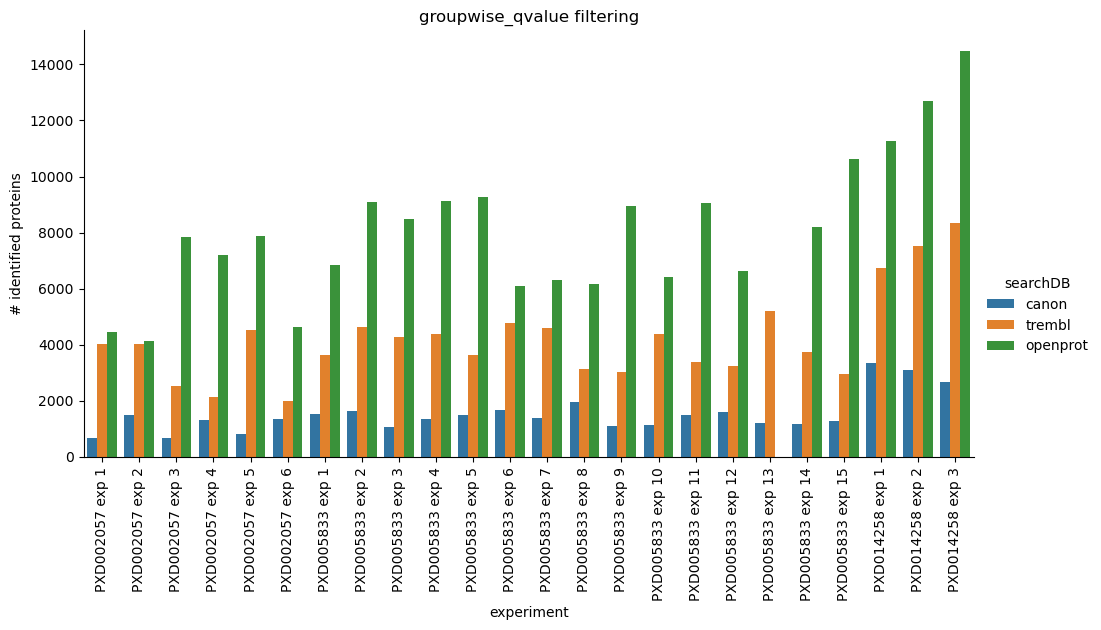

In [57]:
tmp = 'groupwise_qvalue'
combo = combo[(combo[tmp]<.01)&(combo.database=='T')&(combo.isCanonical!='Contam')]
combo.proteins = combo.proteins.str.split(',')
combo = combo.explode('proteins')
combo.drop_duplicates(['proteins','experiment','searchDB'], inplace=True)

sns.catplot(data=combo, kind='count', x='exp_number', hue='searchDB', aspect=2, )#palette=list(project_palette.values()))
plt.xticks(rotation=90)
plt.xlabel('experiment')
plt.ylabel('# identified proteins')
plt.title(f'{tmp} filtering')

#plt.savefig(savefig_path, dpi=300, bbox_inches='tight')